# Network Metrics
Includes analysis and visualizations based on degree distributions. Most bipartite networks analyzed in the literature are not directed. That means that each node has a single degree, which is simply the number of links that node has. -

Our $pq$-network is directed. This means that each node had two degrees: in-degree (the number of links going into the node) and out-degree (the number of links going out of the node). So we have four degree distributions: distribution of in-degrees of $p$-nodes, distribution of out-degrees of $p$-nodes; distribution of in-degrees of $q$-nodes; and distribution
of out-degrees of $q$-nodes. The last distribution is trivial since all q-nodes have out-degree equal to 1 (each question is asked by a single person). Thus, we can characterize each $pq$-network by three degree distributions.

In [4]:
import xlrd 
import matplotlib.pyplot as plt
import matplotlib.colorbar
import matplotlib.colors
import matplotlib.cm
import numpy as np
import pandas as pd
from scipy.stats import chisquare
from math import factorial
from math import exp
from scipy.stats.distributions import chi2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter

import os 

from pq_helper import get_dataframe

We will define the following helper function:

In [151]:
def chi_squared_test(observed, mu, total):
    expected = []
    sum = 0
    for value in range(len(observed) - 1): 
        expected.append(total * (exp(-mu) * mu**value / factorial(value)))
        sum += total * (exp(-mu) * mu**value / factorial(value))
    expected.append(total - sum)
    (testStatistic, pValue) = chisquare(observed, f_exp=expected, 
                                        ddof=len(observed) - 2)  
    p = chi2.sf(testStatistic, len(observed) - 1)
    return (testStatistic, p)    

First, load in the data:

In [73]:
data_path = 'data/'
path = os.path.join(data_path, 'acm95a100a2018_anonymized_modified.xlsx')
(p_nodes, q_nodes, links, mod_p_nodes) = get_dataframe(path)

In [59]:
p_nodes

,ID,Role,Class,Option,Section,DaysOnline,Views,Contributions,Questions,Notes,Answers,N-Score,Grade,Status,In-Degree,Out-Degree,Seniority
0,P1,Student,U2,ME,5.0,48,60,0,0,0,0,0.531170,B+,0,0,0,U
1,P2,Student,U2,ACM,5.0,150,219,14,0,0,13,0.918357,A+,1,1,5,U
2,P3,Student,U2,ACM,7.0,245,215,9,1,0,4,0.864791,A+,1,4,4,U
3,P4,Student,U3,CS,1.0,107,215,3,0,0,2,0.928847,A+,1,0,3,U
4,P5,Student,U2,ME,3.0,53,216,38,10,0,15,0.944688,A+,1,20,9,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,P192,TA,NaN,NaN,8.0,59,88,1,0,0,0,NaN,NaN,1,0,1,N
192,P193,TA,NaN,NaN,9.0,78,34,0,0,0,0,NaN,NaN,1,0,1,N
193,P194,TA,NaN,NaN,10.0,36,53,3,0,2,1,NaN,NaN,0,0,0,N
194,P195,Head TA,NaN,NaN,NaN,74,237,228,0,7,153,NaN,NaN,1,0,125,N


Observe that we have computed In-Degree and Out-Degree for all $p$-nodes and In-Degree for all $q$-nodes and added these node attributes to `acm95a100a2018_anonymized_modified.xlsx`. We reproduce the code for generating the degrees below:

```{python}
# p-node Out-Degree
p_nodes['Out-Degree'] = [0]*len(p_nodes)

out = links["Start"].value_counts()
nodes = links["Start"].value_counts().index

for node in nodes:
    if node[0] == 'P':
        row_index = int(node[1:]) - 1
        p_nodes.loc[row_index, 'Out-Degree'] = out.loc[node]
     
# p-node and q-node In-Degree
p_nodes['In-Degree'] = [0]*len(p_nodes)
q_nodes['In-Degree'] = [0]*len(q_nodes)

ins = links["End"].value_counts()
nodes = links["End"].value_counts().index
for node in nodes:
    row_index = int(node[1:]) - 1
    if node[0] == 'P':
        p_nodes.loc[row_index, 'In-Degree'] = ins.loc[node]
    else:
        q_nodes.loc[row_index, 'In-Degree'] = ins.loc[node]
```

We extract all unique values of In-Degree and Out-Degree for $p$-nodes in ascending order for later use. Most of our analysis will be done on students only, as instructor and TAs are expected to participate heavily in the network, unlike students.

In [58]:
# list of p-nodes out-degrees (students only)
p_node_out = np.sort(mod_p_nodes['Out-Degree'].value_counts().index)
    
# list of p-nodes in-degrees (students only; note that instructors should 
# all have in-degrees of zero, since they don't ask questions)
p_node_in = np.sort(mod_p_nodes['In-Degree'].value_counts().index) 

For our first visualization, we plot the average In-Degree of $p$-nodes against Out-Degree, coloring by average `NScore`:

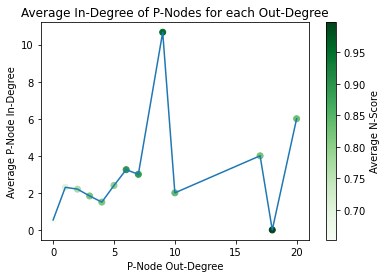

In [87]:
avg_p_in = [] # holds average in-degree of p-nodes with each out-degree 
avg_n_score = [] # holds average n-score of p-nodes with each out-degree
for x in p_node_out: 
    total_in = 0
    total_n = 0
    number = 0 
    for i in range(184):
        if mod_p_nodes['Out-Degree'][i] == x:
            total_in += mod_p_nodes['In-Degree'][i]
            number += 1
            total_n += mod_p_nodes['N-Score'][i]
    avg_p_in.append(total_in / number)  
    avg_n_score.append(total_n / number)
        
plt.scatter(p_node_out, avg_p_in, c=avg_n_score, cmap='Greens')
c = plt.colorbar()
c.set_label('Average N-Score')
plt.plot(p_node_out, avg_p_in)
plt.xlabel('P-Node Out-Degree')
plt.ylabel('Average P-Node In-Degree')
plt.title('Average In-Degree of P-Nodes for each Out-Degree') 
plt.show()

We do the same for average Out-Degree against In-Degree:

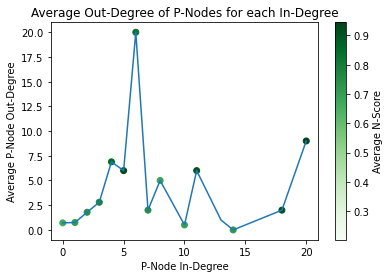

In [88]:
avg_p_out = [] # holds average out-degree of p-nodes with each in-degree 
avg_n_score2 = [] # holds average n-score of p-nodes with each in-degree
for x in p_node_in: 
    total_out = 0
    total_n2 = 0
    number2 = 0 
    for i in range(184):
        if mod_p_nodes['In-Degree'][i] == x:
            total_out += mod_p_nodes['Out-Degree'][i]
            number2 += 1
            total_n2 += mod_p_nodes['N-Score'][i]
    avg_p_out.append(total_out / number2)  
    avg_n_score2.append(total_n2 / number2)
        
plt.scatter(p_node_in, avg_p_out, c=avg_n_score2, cmap='Greens')
c = plt.colorbar()
c.set_label('Average N-Score')
plt.plot(p_node_in, avg_p_out)
plt.xlabel('P-Node In-Degree')
plt.ylabel('Average P-Node Out-Degree')
plt.title('Average Out-Degree of P-Nodes for each In-Degree') 
plt.show()

There is no obvious trend between Out-Degree and In-Degree. Looking at the average `NScore`s, it appears that those $p$-nodes with the highest in-degree (asked a lot of questions) did tend to have relatively high `NScore`s.

Next, we wish to visualize the degree distributions for each type of node. We work with Status $=1$ $p$-nodes only, as those who did not participate in the network have In- and Out-Degrees of 0. We begin with the In-Degrees of $p$-nodes:

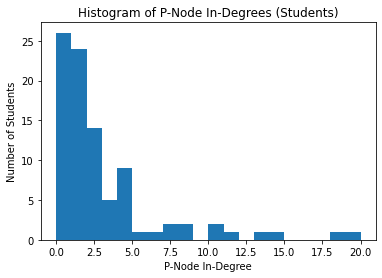

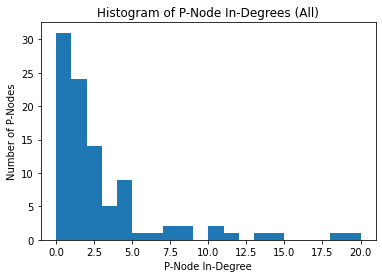

In [102]:
# list of in-degrees of status=1 p-nodes (students only) 
status1_in = mod_p_nodes[:184].loc[mod_p_nodes[:184]['Status'] == 1]['In-Degree']
    
plt.hist(status1_in, bins=20, range=(0, 20))
plt.xlabel('P-Node In-Degree')
plt.ylabel('Number of Students')
plt.title('Histogram of P-Node In-Degrees (Students)')
plt.show()
    
# list of in-degrees of status=1 p-nodes (including TAs and instructor) 
status1_in_all = p_nodes.loc[p_nodes['Status'] == 1]['In-Degree']  

plt.hist(status1_in_all, bins=20, range=(0, 20))
plt.xlabel('P-Node In-Degree')
plt.ylabel('Number of P-Nodes')
plt.title('Histogram of P-Node In-Degrees (All)')
plt.show()

The distribution of $p$-node In-Degrees is skewed to the right, with most participants in the network asking 5 or fewer questions. With the addition of instructors and TAs, who may have made some administrative posts, the number of $p$-nodes with In-Degree 1 increases slightly. Otherwise, the two plots are identical.

Next, we examine the Out-Degrees of $p$-nodes:

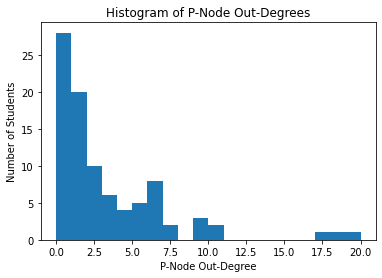

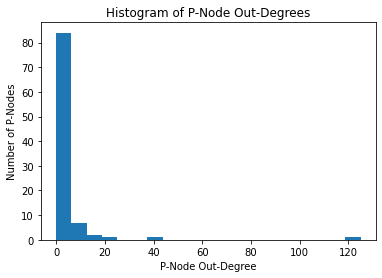

In [105]:
# list of out-degrees of status=1 p-nodes (students only) 
status1_out = mod_p_nodes[:184].loc[mod_p_nodes[:184]['Status'] == 1]['Out-Degree']

plt.hist(status1_out, bins=20, range=(0, 20))
plt.xlabel('P-Node Out-Degree')
plt.ylabel('Number of Students')
plt.title('Histogram of P-Node Out-Degrees')  
plt.show()

# list of out-degrees of status=1 p-nodes (including TAs and instructor) 
status1_out_all = p_nodes.loc[p_nodes['Status'] == 1]['Out-Degree']

plt.hist(status1_out_all, bins=20, range=(0, 125))
plt.xlabel('P-Node Out-Degree')
plt.ylabel('Number of P-Nodes')
plt.title('Histogram of P-Node Out-Degrees')
plt.show()

We again observe distributions skewed to the right, with most participants answering less than 8 questions. A few large outliers exist among students who answered nearly 20 questions. With the addition of instructor and TAs, we see many more large outliers, as expected, since instructor and TAs answered most of the questions posed. 

Finally, we look at $q$-node In-Degrees:

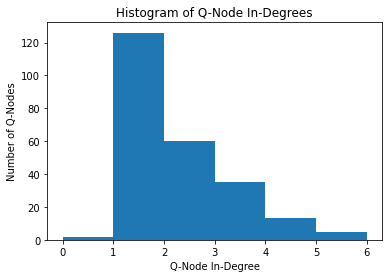

In [106]:
plt.hist(q_nodes['In-Degree'], bins=6, range=(0, 6))
plt.xlabel('Q-Node In-Degree')
plt.ylabel('Number of Q-Nodes')
plt.title('Histogram of Q-Node In-Degrees')
plt.show()

The distribution is somewhat skewed to the right, with most questions answered by 1-3 people. Only two questions were not answered, as instructor and TAs ensured that most questions were answered. 

We next use the $\chi^2$ goodness of fit test to test whether the degree distributions are Poisson. That is, we will use it to determine whether there is a statistically significant difference between the expected frequencies (according to the Poisson distribution) and the observed frequencies of In- and Out-Degrees.

Recall the Poisson PMF: 

$$f(k; \mu) = \frac{\mu^ke^{-\mu}}{k!}$$

where $\mu$ is the mean of the distribution and $k$ represents the degree frequency (bin). Our null hypothesis is that the degree distributions are Poisson.

First, we compute the test statistic and p-value for $p$-node In-Degree. We first examine the observed In-Degree values (for all $p$-nodes):

In [112]:
Counter(status1_in_all)

Counter({1: 24,
         4: 9,
         0: 31,
         20: 1,
         3: 5,
         13: 1,
         2: 14,
         8: 2,
         10: 2,
         14: 1,
         7: 2,
         11: 1,
         6: 1,
         5: 1,
         18: 1})

To ensure that the bin size for the $\chi^2$ test remains greater than 5, we combine In-Degrees of greater than 5 into the same bin. The bins are as follows: 0, 1, 2, 3, 4, 5+. There are $6 - 1 - 1 = 4$ degrees of freedom, since we have 6 bins and one estimated parameter $\mu$ for the Poisson distribution. 

In [140]:
(testStatistic1, pValue1) = chi_squared_test([31, 24, 14, 5, 9, 13], np.mean(status1_in_all), 196)
print(testStatistic1, pValue1)

93.56395512364888 1.197225941251189e-18


The p-value is negligible, suggesting that the $p$-node In-Degree (including all $p$-nodes) does not follow a Poisson distribution.

We perform the same test for $p$-node In-Degree using student nodes only:

In [121]:
Counter(status1_in)

Counter({1.0: 24,
         4.0: 9,
         0.0: 26,
         20.0: 1,
         3.0: 5,
         13.0: 1,
         2.0: 14,
         8.0: 2,
         10.0: 2,
         14.0: 1,
         7.0: 2,
         11.0: 1,
         6.0: 1,
         5.0: 1,
         18.0: 1})

The bins are as follows: 0, 1, 2, 3, 4, 5+  

In [148]:
(testStatistic2, pValue2) = chi_squared_test([26, 24, 14, 5, 9, 13], np.mean(status1_in), 184) 
print(testStatistic2, pValue2)

85.07132096075851 7.273009584078072e-17


The p-value is again negligible, suggesting that the $p$-node In-Degree (including students only) does not follow a Poisson distribution.

We perform the same test for $p$-node Out-Degree using all nodes:

In [118]:
Counter(status1_out_all)

Counter({5: 5,
         4: 4,
         3: 6,
         9: 3,
         0: 28,
         1: 23,
         6: 8,
         7: 2,
         2: 10,
         17: 1,
         18: 1,
         10: 2,
         20: 1,
         125: 1,
         39: 1})

The bins are as follows: 0, 1, 2, 3, 4, 5, 6, 7+  

In [143]:
(testStatistic3, pValue3) = chi_squared_test([28, 23, 10, 6, 4, 5, 8, 12], np.mean(status1_out_all) , 196)
print(testStatistic3, pValue3)

423.4946608096509 2.1747280484521866e-87


The p-value is again negligible, suggesting that the $p$-node Out-Degree (including all nodes) does not follow a Poisson distribution.

We perform the same test for $p$-node Out-Degree with student nodes only:

In [125]:
Counter(status1_out)

Counter({5.0: 5,
         4.0: 4,
         3.0: 6,
         9.0: 3,
         0.0: 28,
         1.0: 20,
         6.0: 8,
         7.0: 2,
         2.0: 10,
         17.0: 1,
         18.0: 1,
         10.0: 2,
         20.0: 1})

The bins are as follows: 0, 1, 2, 3, 4, 5+

In [144]:
(testStatistic4, pValue4) = chi_squared_test([28, 20, 10, 6, 4, 5, 8, 10], np.mean(status1_out), 184)
print(testStatistic4, pValue4)

124.37990595579588 9.364733351533025e-24


The p-value is again negligible, suggesting that the $p$-node Out-Degree (including students only) does not follow a Poisson distribution.

Finally, we perform the same test for $q$-node In-Degree:

In [128]:
q_nodes['In-Degree'].value_counts()

1    126
2     60
3     35
4     13
5      4
0      2
6      1
Name: In-Degree, dtype: int64

The bins are as follows: 0-1, 2, 3, 4, 5+   

In [145]:
observed = [128, 60, 35, 13, 5]
expected = []
total = 241
mu = np.mean(q_nodes['In-Degree'])
sum = 0

# first bin, which contains 0 and 1
expected.append(total * (exp(-mu) + exp(-mu) * mu))
sum += total * (exp(-mu) + exp(-mu) * mu)  

# other bins
for value in range(2, 5): 
    expected.append(total * (exp(-mu) * mu**value / factorial(value)))
    sum += total * (exp(-mu) * mu**value / factorial(value))
expected.append(total - sum)

(testStatistic5, p5) = chisquare(observed, f_exp=expected, ddof=4)    
pValue5 = chi2.sf(testStatistic5, len(observed) - 2)
print(testStatistic5, pValue5)

4.9028474129725925 0.17905093790154217


This time, a p-value of $\approx 0.18$ suggests that the In-Degrees of the $q$-nodes do follow a Poisson distribution with parameter $\mu = 1.780083$ (we fail to reject our null hypothesis). Thus, we might expect each question to be answered by about 2 people and for the probability of a question being answered by $n$ people to follow the Poisson PMF.

### Attributions

Notebook created by Amanda Li. 

Modified from `network_metrics_degree_distributions.py` by Amanda Li.